### 0. Imports

In [1]:
import pandas as pd
from datetime import datetime

import statsmodels
import pmdarima

from statsmodels.tsa.seasonal import seasonal_decompose

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.arima import AutoARIMA, ARIMA
from statsmodels.tsa.api import ExponentialSmoothing

from sklearn.metrics import mean_absolute_error

import warnings

In [52]:
warnings.filterwarnings('ignore')

### 1. Load Data

In [2]:
demand = pd.read_csv('../../data/incomplete/clean_pge_demand.csv')
demand

utc  demand_MWh
0      2015-07-22 08:00      1936.0
1      2015-07-22 09:00      1856.0
2      2015-07-22 10:00      1784.0
3      2015-07-22 11:00      1766.0
4      2015-07-22 12:00      1801.0
...                 ...         ...
63078  2022-10-10 13:00      1991.0
63079  2022-10-10 14:00      2227.0
63080  2022-10-10 15:00      2391.0
63081  2022-10-10 16:00      2414.0
63082  2022-10-10 17:00      2414.0

[63083 rows x 2 columns]

In [3]:
demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63083 entries, 0 to 63082
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   utc         63083 non-null  object 
 1   demand_MWh  63083 non-null  float64
dtypes: float64(1), object(1)
memory usage: 985.8+ KB


In [3]:
# convert datetime string to period object
demand['utc'] = [pd.Period(period, freq='H') for period in demand['utc']]

In [5]:
demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63083 entries, 0 to 63082
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype    
---  ------      --------------  -----    
 0   utc         63083 non-null  period[H]
 1   demand_MWh  63083 non-null  float64  
dtypes: float64(1), period[H](1)
memory usage: 985.8 KB


### 2. EDA for Modeling

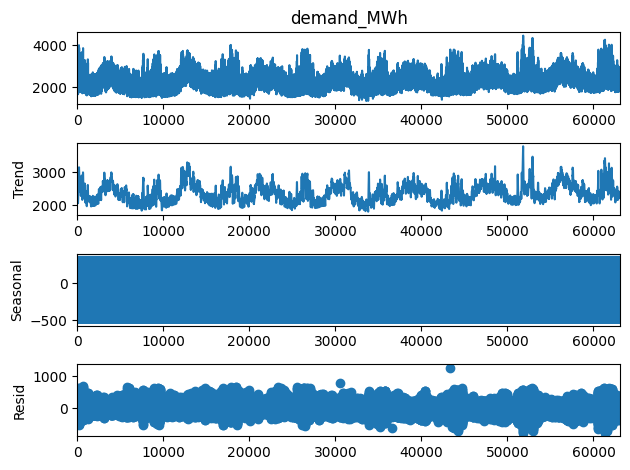

In [6]:
# daily periodicity
seasonal_decompose(demand['demand_MWh'], period=24).plot();

When accounting for daily periodicity, the trend line appears similar to the original series because the most apparent seasonality is annual. The trend is like the daily version of the series, while the seasonal is not interpretable but should show the daily variation pattern.

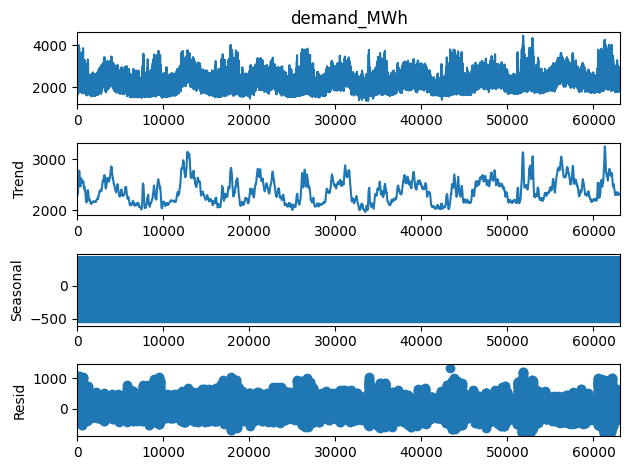

In [7]:
# weekly periodicity
seasonal_decompose(demand['demand_MWh'], period=168).plot();

When accounting for weekly periodicity, the trend line appears similar to the original series, again because the main periodicity is annual. The trend is like the weekly version of the series, while the seasonal graph is uninterpretable but should show the weekly variation pattern.

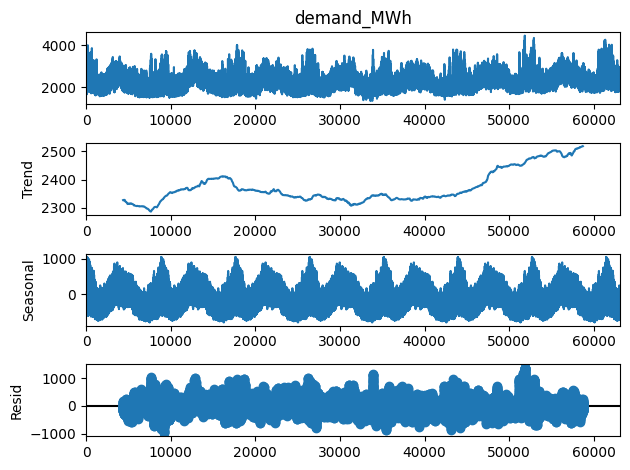

In [8]:
# annual periodicity
seasonal_decompose(demand['demand_MWh'], period=8760).plot();

When accounting for annual periodicity, the trend graph shows no remaining periodicity but instead an irregular and somewhat positive trend. In the seasonal graph, steeper peaks are summers (2015-2022) while more gradual peaks are winters (2015/16 - 2021/22) and troughs are springs and falls.

### 3. Basic Models
- Model, Predict, Plot, and Evaluate:
    - Holt-Winters
    - SARIMA

In [4]:
# setup series and train-test split
y = demand.set_index('utc')['demand_MWh']
y_train, y_test = temporal_train_test_split(y)

#### 3a) Holt-Winters

**HW1: add/add**

In [13]:
hw1 = ExponentialSmoothing(y_train, seasonal_periods=24,
                           trend='add', seasonal='add').fit()
hwpreds1 = hw1.forecast(len(y_test))

C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


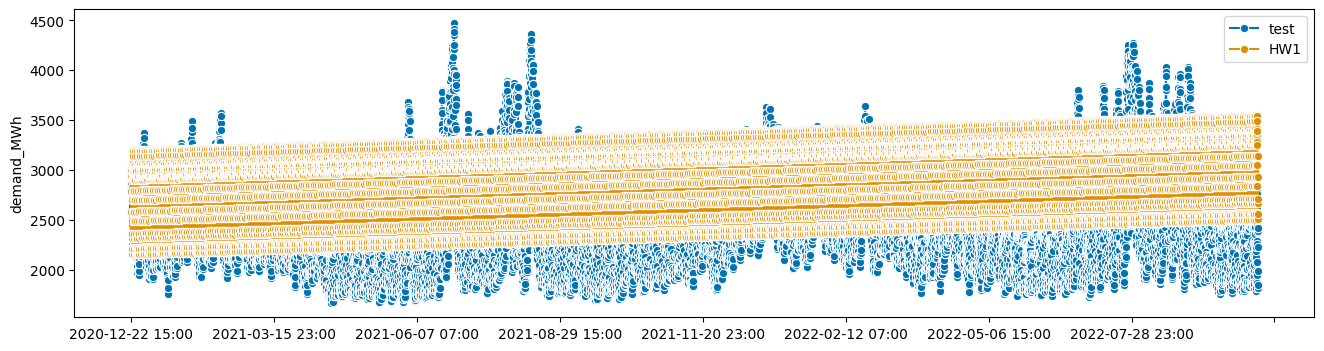

In [14]:
plot_series(y_test, hwpreds1, labels=['test', 'HW1']);

It is unclear from the full plot of predictions against test values whether HW is performing as expected, though a positive (additive) trend is clearly visible.

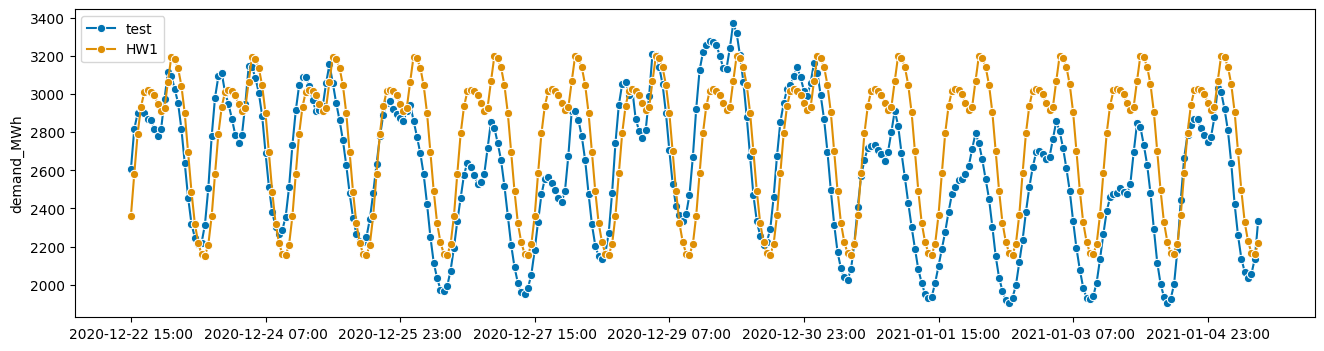

In [23]:
# first two weeks of test period
plot_series(y_test[:336], hwpreds1[:336], labels=['test', 'HW1']);

HW appears to behave as expected, here showing a smoothed week of hourly data. The model's predictions are good during the week, but consistently overestimate electricity demand on the weekends (the 5th, 6th, 12th, and 13th peaks in the test set are much lower than predictions) and certain holidays (the 10th and 11th peaks are New Year's Eve and Day). Different holidays affect demand differently. Christmas Day, on a Friday in 2020, showed only slightly lower than normal Friday demand. New Year's Eve and Day, however, have significantly suppressed demand, appearing very similar to weekends.

Modeling weekday and weekend electricity demand separately, or using a dummy variable for weekend days in a model with exogenous variables, would be effective. Additionally, dummies pertaining to specific holidays should be used. Something about Christmas might keep electricity demand at relatively normal weekday levels when occurring on a weekday. For example, there might be increased home use and use related to commercial events and activities that is compensating for decreased use in closed stores and offices.

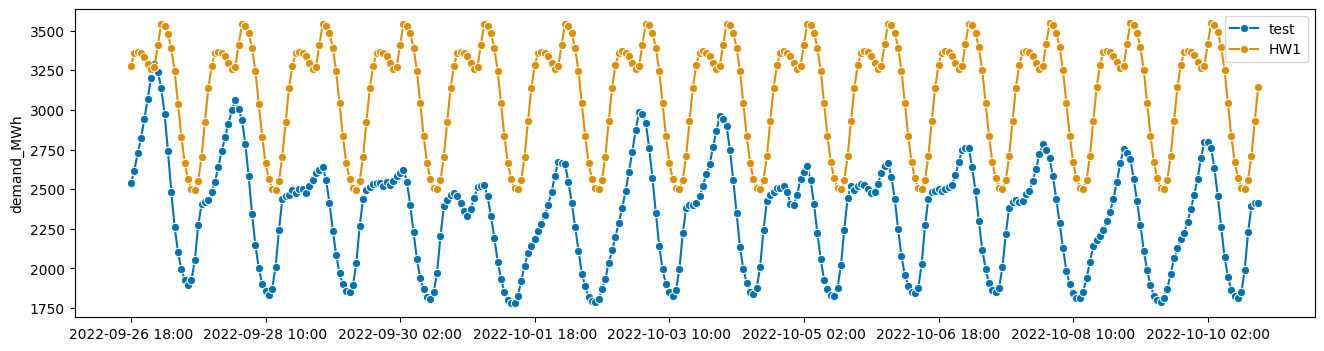

In [55]:
# last two weeks of test period
plot_series(y_test[-336:], hwpreds1[-336:], labels=['test', 'HW1']);

The additive trend seems to make all of the predictions much too high by the end of the test period.

In [15]:
mean_absolute_error(y_test, hwpreds1)

509.5176312408159

The model performs poorly relative to PGE's own day-ahead demand predictions, whose MAE is about 50 MWh. This is no surprise, based on the simplicity of the model and the clear deficiencies in the predictions shown above.

Assuming that, suffering from the same structural inadequacies, other HW models will not show significant improvement over this one, I will model, plot, and evaluate other trend and seasonality combinations for completeness, but will not interpret each one.

**HW2: add/mul**

In [18]:
hw2 = ExponentialSmoothing(y_train, seasonal_periods=24,
                           trend='add', seasonal='mul').fit()
hwpreds2 = hw2.forecast(len(y_test))

C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


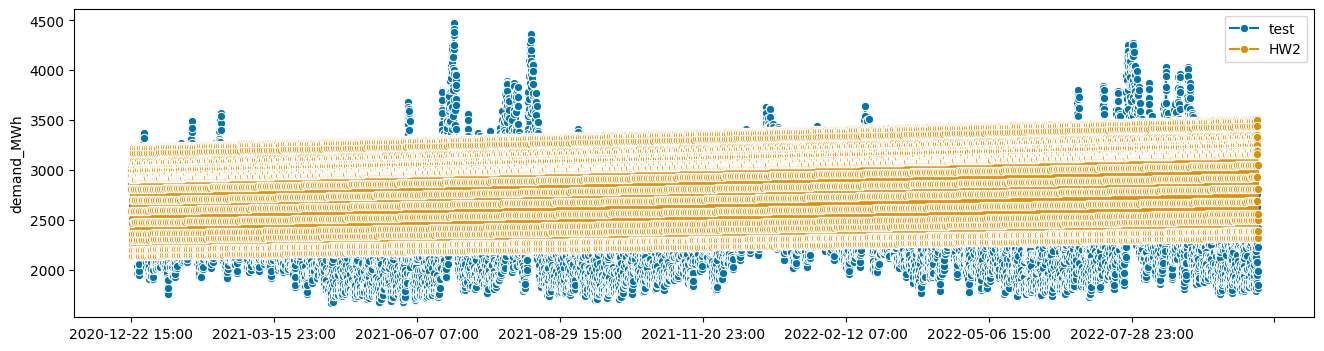

In [19]:
plot_series(y_test, hwpreds2, labels=['test', 'HW2']);

In [20]:
mean_absolute_error(y_test, hwpreds2)

471.93615531827055

**HW3: mul/add**

In [27]:
hw3 = ExponentialSmoothing(y_train, seasonal_periods=24,
                           trend='mul', seasonal='add').fit()
hwpreds3 = hw3.forecast(len(y_test))

C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


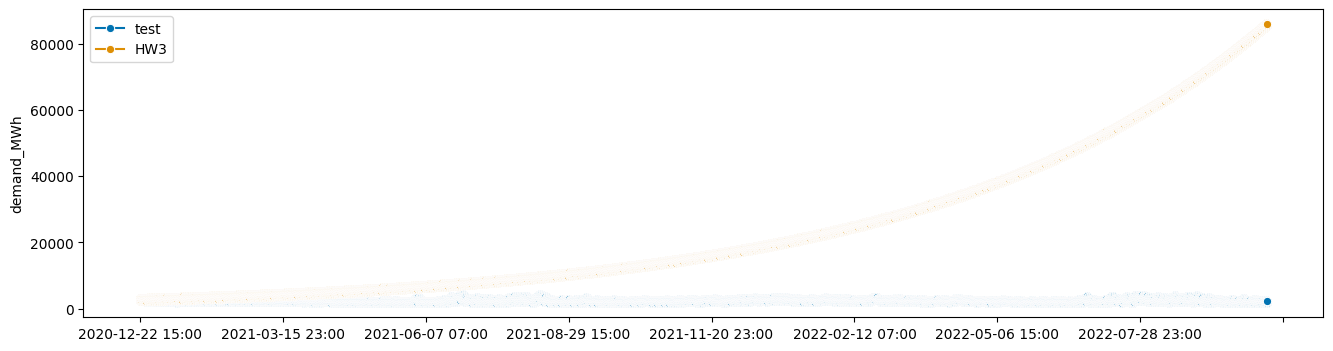

In [28]:
plot_series(y_test, hwpreds3, labels=['test', 'HW3']);

In [31]:
mean_absolute_error(y_test, hwpreds3)

22018.93578900736

**HW4: mul/mul**

In [29]:
hw4 = ExponentialSmoothing(y_train, seasonal_periods=24,
                           trend='mul', seasonal='mul').fit()
hwpreds4 = hw4.forecast(len(y_test))

C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


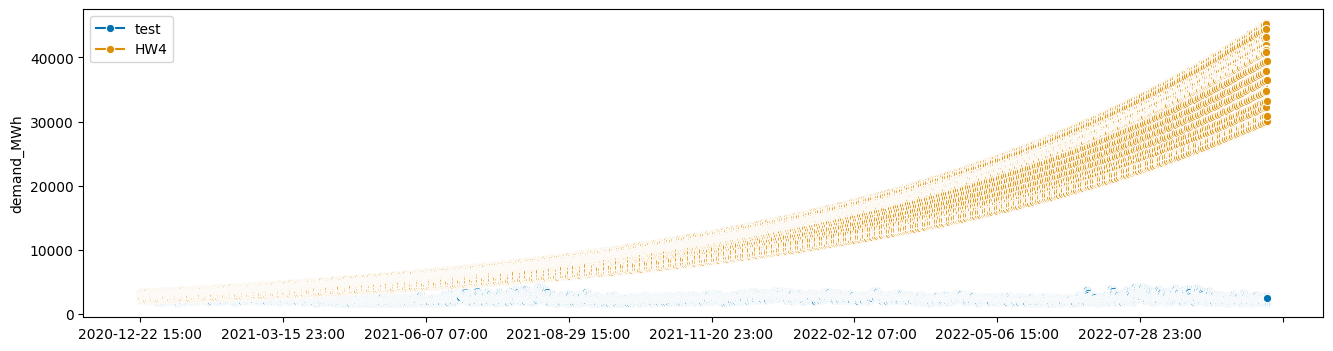

In [32]:
plot_series(y_test, hwpreds4, labels=['test', 'HW4']);

In [33]:
mean_absolute_error(y_test, hwpreds4)

11336.55288288556

**HW5: none/add**

In [34]:
hw5 = ExponentialSmoothing(y_train, seasonal_periods=24,
                           trend=None, seasonal='add').fit()
hwpreds5 = hw5.forecast(len(y_test))

C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


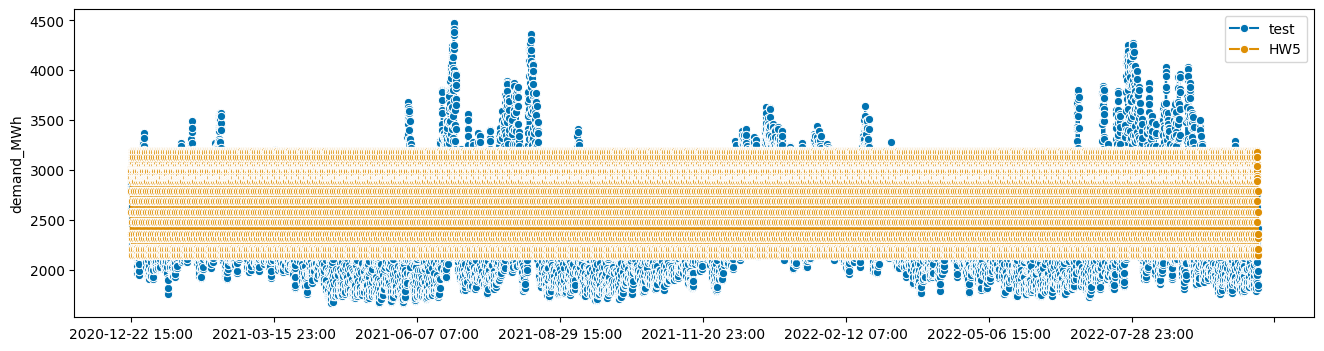

In [35]:
plot_series(y_test, hwpreds5, labels=['test', 'HW5']);

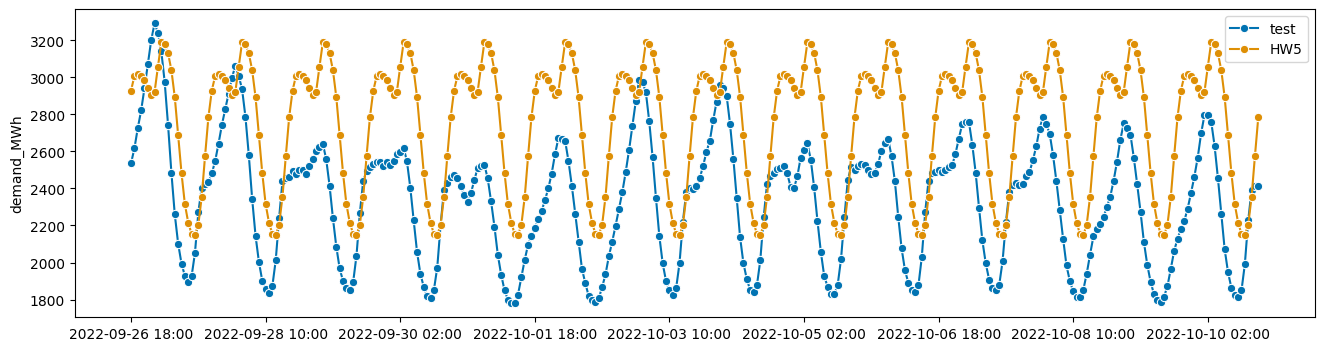

In [56]:
# last two weeks of test period, for comparison with those of HW1, where additive trend was egregious by the end of the period
plot_series(y_test[-336:], hwpreds5[-336:], labels=['test', 'HW5']);

In [36]:
mean_absolute_error(y_test, hwpreds5)

384.5456574589916

**HW6: none/mul**

In [37]:
hw6 = ExponentialSmoothing(y_train, seasonal_periods=24,
                           trend=None, seasonal='mul').fit()
hwpreds6 = hw6.forecast(len(y_test))

C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


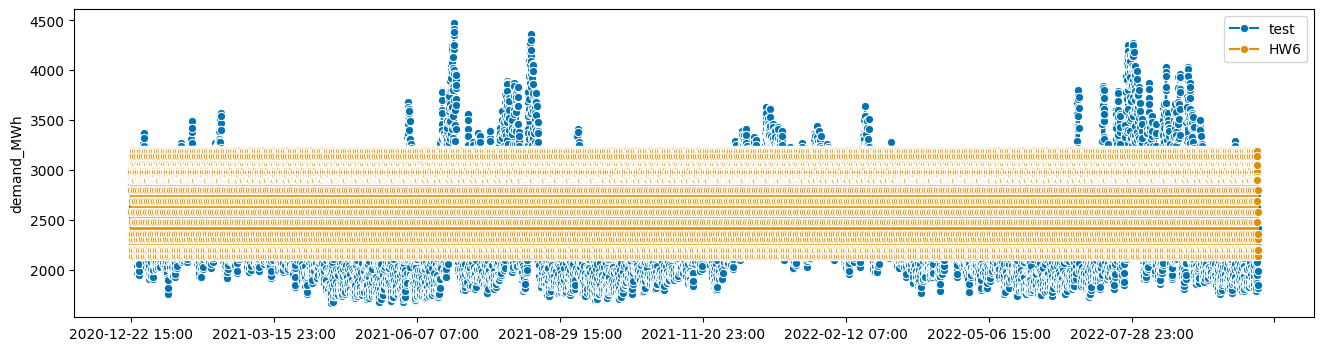

In [38]:
plot_series(y_test, hwpreds6, labels=['test', 'HW6']);

In [39]:
mean_absolute_error(y_test, hwpreds6)

385.1517110140982

A multiplicative trend is clearly inappropriate for this data. No trend at all performs best in these models. Fundamentally though, daily periodicity fails to capture too much of the weekly and annual seasonality in electricity demand for these models to be useful.

#### 3b) SARIMA

**SARIMA1: Best Auto**

In [49]:
# sarima1 = AutoARIMA(sp=24, maxiter=100, trace=True)
# sarima1.fit(y_train)

Performing stepwise search to minimize aic


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=585.05 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=589143.690, Time=0.39 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=inf, Time=50.45 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=552791.562, Time=37.34 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=589141.690, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=568043.116, Time=3.01 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=89.40 sec
 ARIMA(0,1,1)(0,0,2)[24] intercept   : AIC=545203.172, Time=294.15 sec
 ARIMA(0,1,1)(1,0,2)[24] intercept   : AIC=inf, Time=382.71 sec
 ARIMA(0,1,0)(0,0,2)[24] intercept   : AIC=549116.310, Time=313.35 sec
 ARIMA(1,1,1)(0,0,2)[24] intercept   : AIC=541077.391, Time=345.62 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=546218.739, Time=48.75 sec
 ARIMA(1,1,1)(1,0,2)[24] intercept   : AIC=inf, Time=1083.27 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=141.42 sec


MemoryError: Unable to allocate 902. MiB for an array with shape (50, 50, 47312) and data type float64

Best SARIMA before MemoryError: ARIMA(1,1,1)(0,0,2)[24] intercept   : AIC=541077.391, Time=345.62 sec

In [40]:
sarima1 = ARIMA(order=(1,1,1), seasonal_order=(0,0,2,24), maxiter=100)
sarima1.fit(y_train)

ARIMA(maxiter=100, order=(1, 1, 1), seasonal_order=(0, 0, 2, 24))

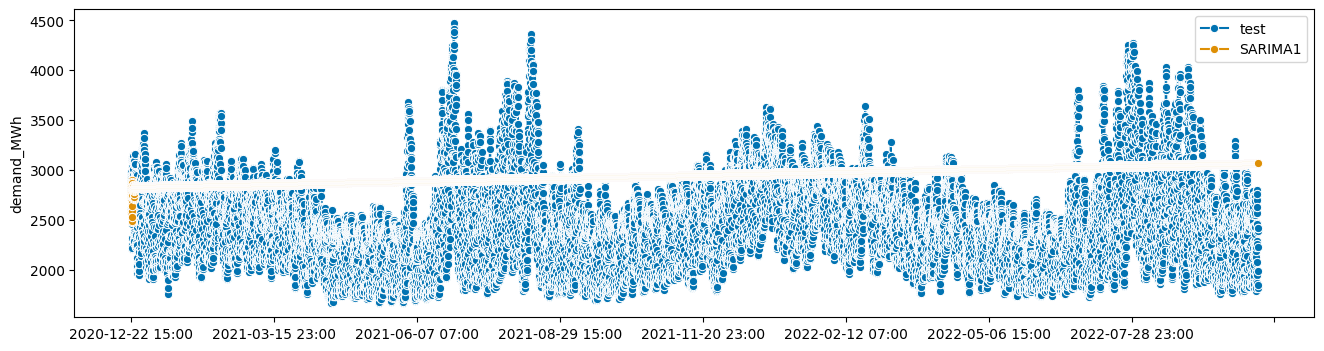

In [42]:
sarpreds1 = sarima1.predict(y_test.index)
plot_series(y_test, sarpreds1, labels=['test', 'SARIMA1']);

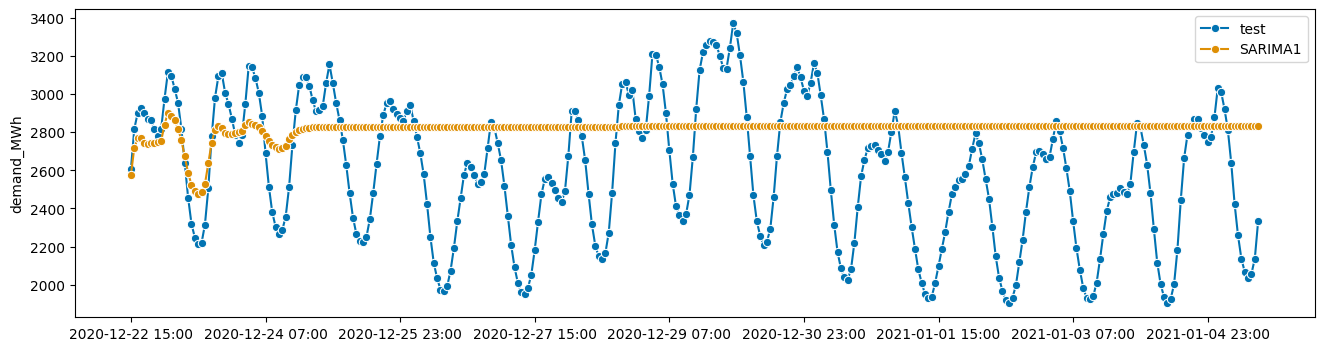

In [43]:
# first two weeks of test period
plot_series(y_test[:336], sarpreds1[:336], labels=['test', 'SARIMA1']);

In [44]:
mean_absolute_error(y_test, sarpreds1)

543.1318451152633

**SARIMA2: SAR(1)(1)[24]**

In [45]:
sarima2 = ARIMA(order=(1,0,0), seasonal_order=(1,0,0,24))
sarima2.fit(y_train)

C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(seasonal_order=(1, 0, 0, 24))

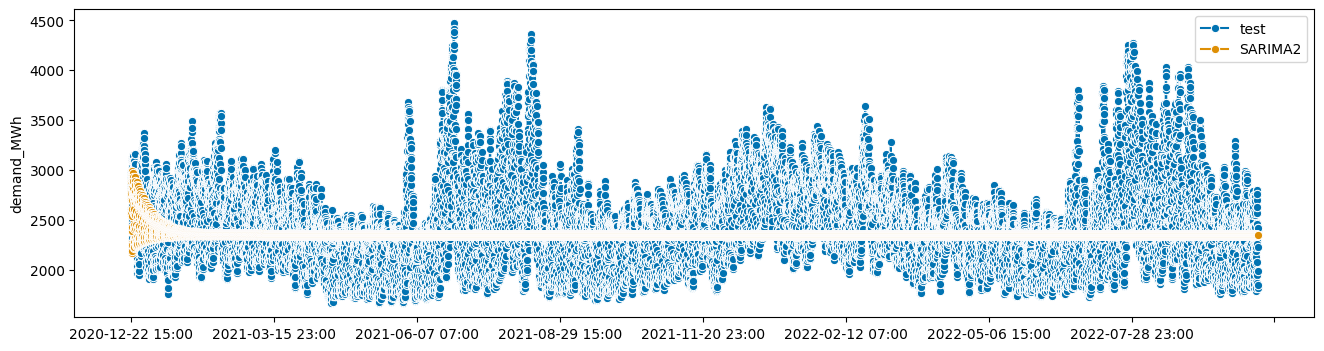

In [49]:
sarpreds2 = sarima2.predict(y_test.index)
plot_series(y_test, sarpreds2, labels=['test', 'SARIMA2']);

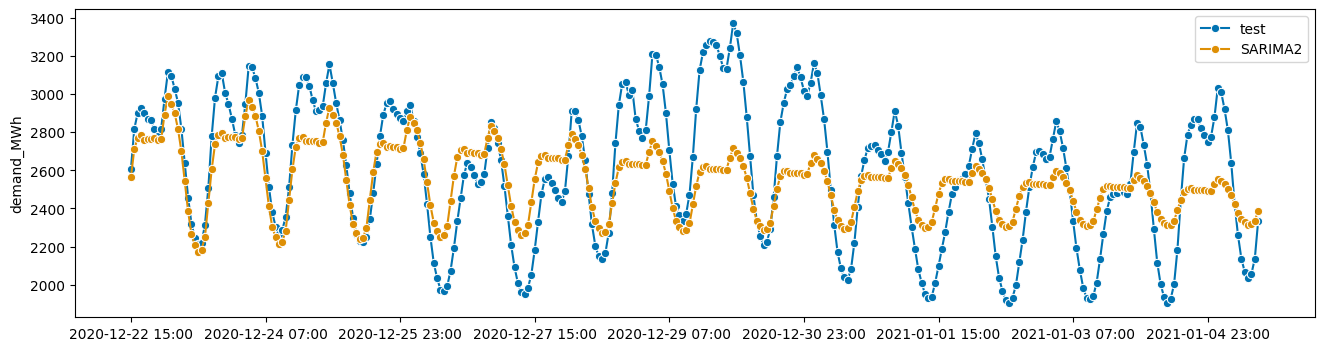

In [50]:
# first two weeks of test period
plot_series(y_test[:336], sarpreds2[:336], labels=['test', 'SARIMA2']);

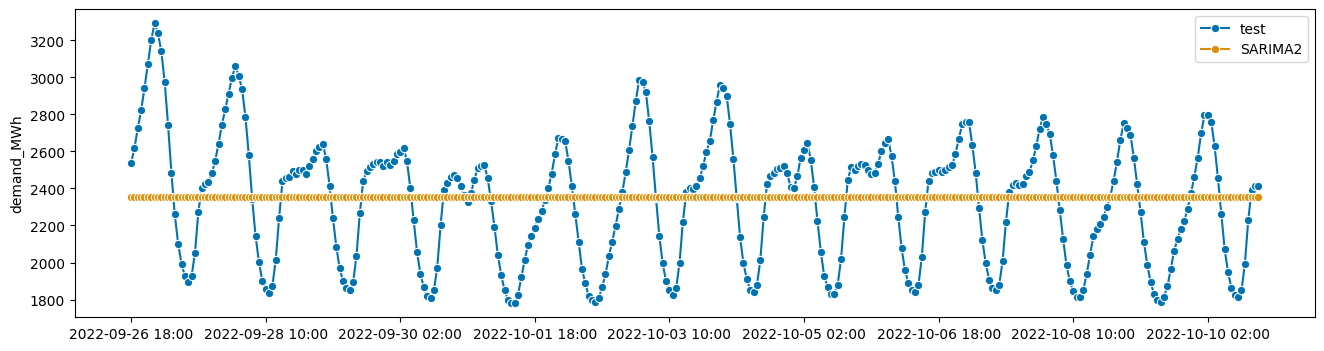

In [53]:
# last two weeks of test period
plot_series(y_test[-336:], sarpreds2[-336:], labels=['test', 'SARIMA2']);

In [54]:
mean_absolute_error(y_test, sarpreds2)

339.0521656287764

In [57]:
sarpreds2[-336:]

2022-09-26 18:00    2352.407185
2022-09-26 19:00    2352.407185
2022-09-26 20:00    2352.407185
2022-09-26 21:00    2352.407185
2022-09-26 22:00    2352.407185
                       ...     
2022-10-10 13:00    2352.407185
2022-10-10 14:00    2352.407185
2022-10-10 15:00    2352.407185
2022-10-10 16:00    2352.407185
2022-10-10 17:00    2352.407185
Freq: H, Length: 336, dtype: float64

In [58]:
y_test.mean()

2486.003867858728

In [59]:
y_train.mean()

2347.1287728271896

Because of the way ARIMA models create forecasts, out-of-sample forecasts converge to a constant. These models are not intended for long time horizon forecasting.

In [60]:
# week-ahead demand forecast quality
mean_absolute_error(y_test[:168], sarpreds2[:168])

158.042907375505

In [62]:
# one week out week-ahead demand forecast quality
mean_absolute_error(y_test[168:336], sarpreds2[168:336])

249.25372488080862

In [61]:
# day-ahead demand forecast quality
mean_absolute_error(y_test[:24], sarpreds2[:24])

88.06173413293986

In [63]:
# one day out day-ahead demand forecast quality
mean_absolute_error(y_test[24:48], sarpreds2[24:48])

135.06695168655727

ARIMA Predictions get significantly worse the longer the time horizon. The next step is to create week-ahead demand predictions, re-fitting model for each set of predictions over various training lengths.

#### 3c) SARIMA with Short Training and Forecasting Periods

- 2 year train, 1 week forecast
- 1 year train, 1 week forecast
- 12 week train, 1 week forecast
- 12 week train, 1 day forecast
- 4 week train, 1 day forecast

In [77]:
# 2 year train, 1 week forecast
y_train_short1, y_test_short1 = temporal_train_test_split(y[:17688], test_size=168)

sar_short1 = ARIMA(order=(1,0,0), seasonal_order=(1,0,0,24))
sar_short1.fit(y_train_short1)

sarpreds_short1 = sar_short1.predict(y_test_short1.index)
mean_absolute_error(y_test_short1, sarpreds_short1)

266.47703080294605

Took 46.71 seconds

In [76]:
# 1 year train, 1 week forecast
y_train_short2, y_test_short2 = temporal_train_test_split(y[:8928], test_size=168)

sar_short2 = ARIMA(order=(1,0,0), seasonal_order=(1,0,0,24))
sar_short2.fit(y_train_short2)

sarpreds_short2 = sar_short2.predict(y_test_short2.index)
mean_absolute_error(y_test_short2, sarpreds_short2)

257.2611922199779

Took 21.25 seconds

In [83]:
# 12 week train, 1 week forecast
y_train_short3, y_test_short3 = temporal_train_test_split(y[:2184], test_size=168)

sar_short3 = ARIMA(order=(1,0,0), seasonal_order=(1,0,0,24))
sar_short3.fit(y_train_short3)

sarpreds_short3 = sar_short3.predict(y_test_short3.index)
mean_absolute_error(y_test_short3, sarpreds_short3)

C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


115.23114983138727

Took 7.86 seconds

In [84]:
# 12 week train, 1 day forecast
y_train_short4, y_test_short4 = temporal_train_test_split(y[:2040], test_size=24)

sar_short4 = ARIMA(order=(1,0,0), seasonal_order=(1,0,0,24))
sar_short4.fit(y_train_short4)

sarpreds_short4 = sar_short4.predict(y_test_short4.index)
mean_absolute_error(y_test_short4, sarpreds_short4)

C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


21.718861698068668

Took 7.75 seconds

In [82]:
# 4 week train, 1 day forecast
y_train_short5, y_test_short5 = temporal_train_test_split(y[:696], test_size=24)

sar_short5 = ARIMA(order=(1,0,0), seasonal_order=(1,0,0,24))
sar_short5.fit(y_train_short5)

sarpreds_short5 = sar_short5.predict(y_test_short5.index)
mean_absolute_error(y_test_short5, sarpreds_short5)

C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


117.07944139908652

Took 3.20 seconds

- Best 1 week forecast: 12 week train (MAE 115.2)
- Best 1 day forecast: 12 week train (MAE 21.7)

In [85]:
# to check decay on prediction quality
# in case predictions are needed during the preceding day (rather than just after midnight)

# 12 week train, 2 day forecast
y_train_short6, y_test_short6 = temporal_train_test_split(y[:2064], test_size=48)

sar_short6 = ARIMA(order=(1,0,0), seasonal_order=(1,0,0,24))
sar_short6.fit(y_train_short6)

sarpreds_short6 = sar_short6.predict(y_test_short6.index)
mean_absolute_error(y_test_short6, sarpreds_short6)

C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


32.98247522590964

Took 7.87 seconds

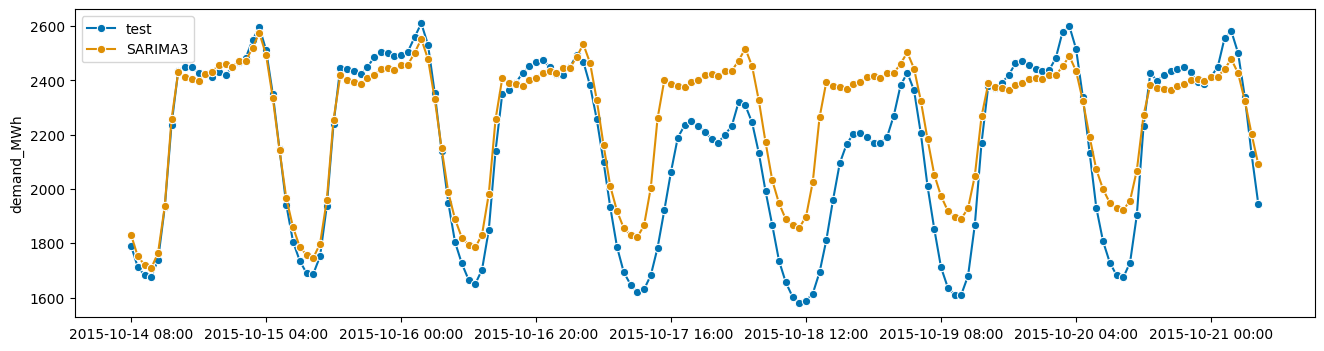

In [87]:
# plot best 1 week model forecast
plot_series(y_test_short3, sarpreds_short3, labels=['test', 'SARIMA3']);

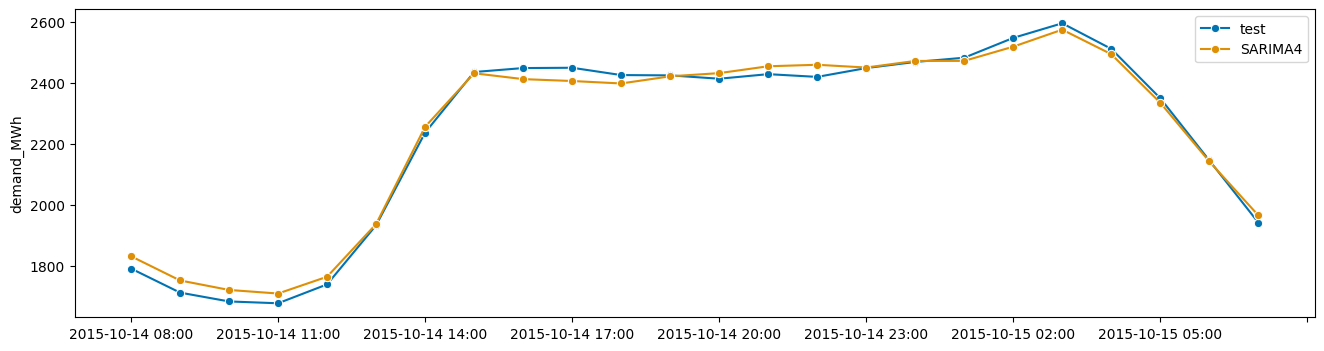

In [86]:
# plot best 1 day model forecast
plot_series(y_test_short4, sarpreds_short4, labels=['test', 'SARIMA4']);

#### 3d) Holt-Winters on Best Train-Time Models

In [89]:
# 12 week train, 1 week forecast
hw_short3 = ExponentialSmoothing(y_train_short3, seasonal_periods=24,
                           trend=None, seasonal='add').fit()
hwpreds_short3 = hw_short3.forecast(len(y_test_short3))
mean_absolute_error(y_test_short3, hwpreds_short3)

116.19388260369405

Took < 0.5 seconds

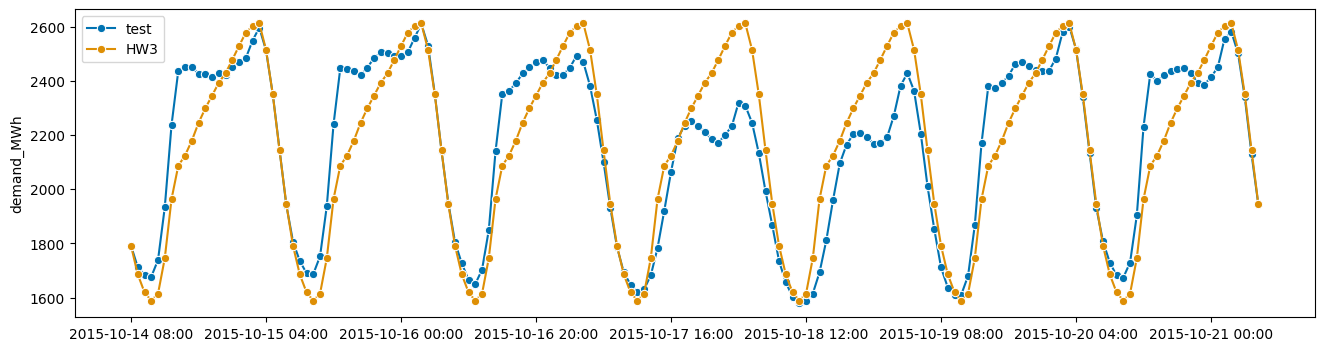

In [92]:
# plot HW 1 week model forecast
plot_series(y_test_short3, hwpreds_short3, labels=['test', 'HW3']);

In [90]:
# 12 week train, 1 day forecast
hw_short4 = ExponentialSmoothing(y_train_short4, seasonal_periods=24,
                           trend=None, seasonal='add').fit()
hwpreds_short4 = hw_short4.forecast(len(y_test_short4))
mean_absolute_error(y_test_short4, hwpreds_short4)

99.75927605618124

Took < 0.5 seconds

Holt-Winters performs similarly on 1 week forecast but much worse on 1 day forecast. It was, however, much faster than ARIMA.

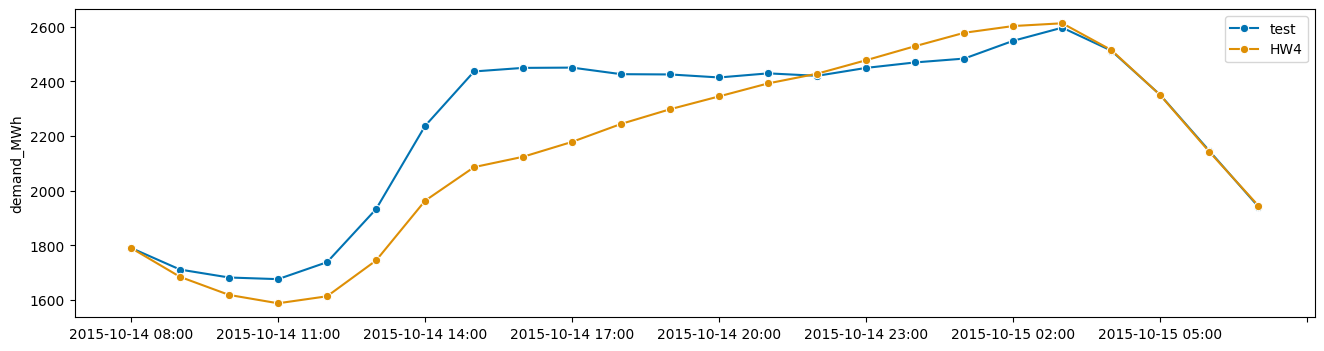

In [91]:
# plot HW 1 day model forecast
plot_series(y_test_short4, hwpreds_short4, labels=['test', 'HW4']);

- Holt-Winters is better at capturing transitions between night and day.
- SARIMA is better at capturing fluctuations during the day.
- Both are bad at capturing weekends.

This suggests using SARIMA forecasts for daytime hours and HW forecasts for nighttime hours, and incorporating a weekend dummy variable.

**AutoARIMA for Short Training and Forecasting Periods:**

In [93]:
auto_sar_short = AutoARIMA(sp=24, trace=True)
auto_sar_short.fit(y_train_short3)

Performing stepwise search to minimize aic


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=19653.799, Time=8.80 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=24895.949, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=inf, Time=2.78 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=21783.239, Time=1.92 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=24893.949, Time=0.02 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(0,0,1)[24] intercept   : AIC=20667.798, Time=5.67 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,0,0)[24] intercept   : AIC=inf, Time=7.84 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(2,0,1)[24] intercept   : AIC=inf, Time=45.00 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,0,2)[24] intercept   : AIC=inf, Time=44.81 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(0,0,0)[24] intercept   : AIC=21534.522, Time=0.71 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(0,0,2)[24] intercept   : AIC=inf, Time=43.49 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(2,0,0)[24] intercept   : AIC=inf, Time=43.36 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(2,0,2)[24] intercept   : AIC=inf, Time=54.01 sec
 ARIMA(1,1,2)(1,0,1)[24] intercept   : AIC=19708.032, Time=7.61 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=8.25 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=10.58 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,1,3)(1,0,1)[24] intercept (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(2,1,3)(1,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=19716.996, Time=5.03 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,1,3)(1,0,1)[24] intercept   : AIC=19714.302, Time=10.79 sec
 ARIMA(3,1,1)(1,0,1)[24] intercept   : AIC=19709.130, Time=7.47 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,1,3)(1,0,1)[24] intercept   : AIC=inf, Time=15.87 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(1,0,1)[24]             : AIC=19651.793, Time=6.05 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(0,0,1)[24]             : AIC=20665.814, Time=2.85 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,0,0)[24]             : AIC=inf, Time=4.07 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(2,0,1)[24]             : AIC=inf, Time=38.55 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,0,2)[24]             : AIC=inf, Time=42.81 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(0,0,0)[24]             : AIC=21532.541, Time=0.46 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(0,0,2)[24]             : AIC=inf, Time=24.37 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(2,0,0)[24]             : AIC=inf, Time=17.14 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(2,0,2)[24]             : AIC=inf, Time=53.33 sec
 ARIMA(1,1,2)(1,0,1)[24]             : AIC=19706.032, Time=3.91 sec
 ARIMA(2,1,1)(1,0,1)[24]             : AIC=inf, Time=4.50 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,1,2)(1,0,1)[24]             : AIC=inf, Time=7.74 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,3)(1,0,1)[24]             : AIC=inf, Time=11.63 sec
 ARIMA(1,1,1)(1,0,1)[24]             : AIC=19714.997, Time=2.91 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,1,3)(1,0,1)[24]             : AIC=19707.208, Time=7.56 sec
 ARIMA(3,1,1)(1,0,1)[24]             : AIC=19707.131, Time=4.55 sec
 ARIMA(3,1,3)(1,0,1)[24]             : AIC=inf, Time=12.25 sec

Best model:  ARIMA(2,1,2)(1,0,1)[24]          
Total fit time: 591.811 seconds


AutoARIMA(sp=24, trace=True)

Best SARIMA for 12-week train:  ARIMA(2,1,2)(1,0,1)[24]

In [94]:
auto_sarpreds_short3 = auto_sar_short.predict(y_test_short3.index)
mean_absolute_error(y_test_short3, auto_sarpreds_short3)

114.9658671051428

In [95]:
auto_sarpreds_short4 = auto_sar_short.predict(y_test_short4.index)
mean_absolute_error(y_test_short4, auto_sarpreds_short4)

34.50520673721574

The best SARIMA model produced by AutoARIMA is only marginally better for a 1-week forecasting horizon and is significantly worse for a 1-day forecasting horizon, so the simpler ARIMA(1,0,0)(1,0,0)[24] model will be used going forward.

### 4. Iterative Forecasting

- HW:
    - Iterate fitting through 12-week training periods (overlapping in 11 weeks) to make one week ahead forecasts for 13th through final week of demand series
        - redundant with SARIMA fitting, but should be very fast
    - Iterate fitting through 12-week training periods (overlapping in 12 weeks minus one day) to make one day ahead forecasts for 169th through final day of demand series
        - redundant with SARIMA fitting, but should be very fast
- ARIMA:
    - Iterate fitting through 12-week training periods (overlapping in 11 weeks) to make one week ahead forecasts for 13th through final week of demand series
    - Iterate fitting through 12-week training periods (overlapping in 12 weeks minus one day) to make one day ahead forecasts for 169th through final day of demand series

**HW 12-week Train, 1-week Forecast:**

In [5]:
y.shape

(63083,)

In [113]:
# number of hours in 1 week:
24*7

168

In [111]:
# number of whole weeks in demand series
63083 // 168

375

In [114]:
# number of weeks for which I can generate forecasts based on previous 12 weeks:
375-12

363

In [112]:
# number of hours in 12 weeks:
24*7*12

2016

In [5]:
# HW forecasts for weeks 13 through 375
iter_hwpreds_week = []

for n in range(363):
    y_12weektrain = y[168*n: 2016 + 168*n]
    forecast_length = 168
    
    iter_hw_week = ExponentialSmoothing(y_12weektrain, seasonal_periods=24, trend=None, seasonal='add').fit()
    iter_hwpreds_week.append(iter_hw_week.forecast(forecast_length))

Took about 8 seconds

In [7]:
iter_hwpreds_week[:2]

[2015-10-14 08:00    1790.959028
 2015-10-14 09:00    1685.334006
 2015-10-14 10:00    1619.367708
 2015-10-14 11:00    1588.807563
 2015-10-14 12:00    1614.398388
                        ...     
 2015-10-21 03:00    2612.010141
 2015-10-21 04:00    2514.346021
 2015-10-21 05:00    2349.310592
 2015-10-21 06:00    2142.669925
 2015-10-21 07:00    1945.700041
 Freq: H, Length: 168, dtype: float64,
 2015-10-21 08:00    1829.029173
 2015-10-21 09:00    1759.744911
 2015-10-21 10:00    1728.251330
 2015-10-21 11:00    1728.581665
 2015-10-21 12:00    1782.970788
                        ...     
 2015-10-28 03:00    2486.254979
 2015-10-28 04:00    2417.316559
 2015-10-28 05:00    2276.639241
 2015-10-28 06:00    2102.774214
 2015-10-28 07:00    1952.520350
 Freq: H, Length: 168, dtype: float64]

In [8]:
iter_hwpreds_week[-2:]

[2022-09-23 07:00    2015.382892
 2022-09-23 08:00    1846.365609
 2022-09-23 09:00    1724.963373
 2022-09-23 10:00    1642.057340
 2022-09-23 11:00    1602.635006
                        ...     
 2022-09-30 02:00    2786.054134
 2022-09-30 03:00    2737.635481
 2022-09-30 04:00    2633.158655
 2022-09-30 05:00    2449.856352
 2022-09-30 06:00    2231.730785
 Freq: H, Length: 168, dtype: float64,
 2022-09-30 07:00    2005.496074
 2022-09-30 08:00    1820.483306
 2022-09-30 09:00    1684.634599
 2022-09-30 10:00    1589.426601
 2022-09-30 11:00    1537.426256
                        ...     
 2022-10-07 02:00    2757.233398
 2022-10-07 03:00    2717.089878
 2022-10-07 04:00    2612.843675
 2022-10-07 05:00    2440.871724
 2022-10-07 06:00    2225.936669
 Freq: H, Length: 168, dtype: float64]

In [135]:
# how far from end of y weekly predictions stop
63083 - 375*168

83

In [155]:
# check indices needed for converting predictions list to pandas series with period index
y.index[2016:-83]

PeriodIndex(['2015-10-14 08:00', '2015-10-14 09:00', '2015-10-14 10:00',
             '2015-10-14 11:00', '2015-10-14 12:00', '2015-10-14 13:00',
             '2015-10-14 14:00', '2015-10-14 15:00', '2015-10-14 16:00',
             '2015-10-14 17:00',
             ...
             '2022-10-06 21:00', '2022-10-06 22:00', '2022-10-06 23:00',
             '2022-10-07 00:00', '2022-10-07 01:00', '2022-10-07 02:00',
             '2022-10-07 03:00', '2022-10-07 04:00', '2022-10-07 05:00',
             '2022-10-07 06:00'],
            dtype='period[H]', name='utc', length=60984)

In [6]:
# convert to pandas series
iter_hwpreds_week_flat = pd.Series([pred for l in iter_hwpreds_week for pred in l], index=y.index[2016:-83])

In [157]:
len(iter_hwpreds_week_flat)

60984

In [158]:
mean_absolute_error(y[2016:-83], iter_hwpreds_week_flat)

194.2372989785015

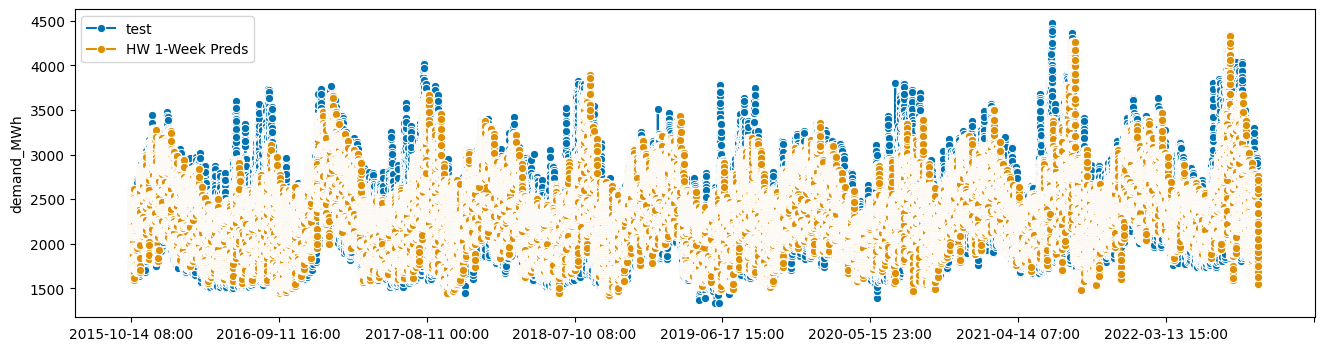

In [159]:
plot_series(y[2016:-83], iter_hwpreds_week_flat, labels=['test', 'HW 1-Week Preds']);

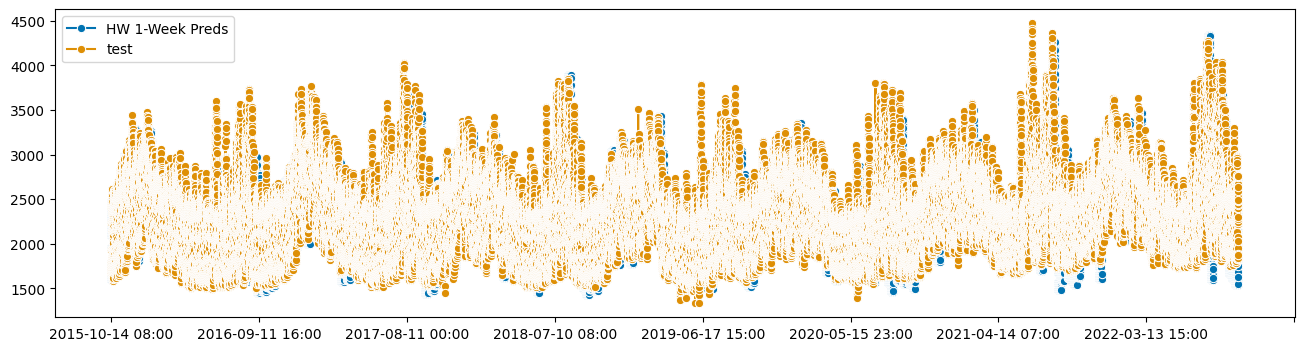

In [179]:
plot_series(iter_hwpreds_week_flat, y[2016:-83], labels=['HW 1-Week Preds', 'test']);

The HW 12-week train model with daily periodicity does a reasonable job of forecasting one week out, and does so very quickly. It fails to capture some of the more extreme summer demand spikes, but at cursory glance does well with the more gradual winter troughs. Overall, the forecasts show less variation than the data, which makes sense based on the "smoothing" idea of HW.

**HW 12-week Train, 1-day Forecast:**

In [160]:
# number of whole days in demand series
63083 // 24

2628

In [162]:
# number of days in 12 weeks
7 * 12

84

In [161]:
# number of days for which I can generate forecasts based on previous 12 weeks:
2628 - 84

2544

In [7]:
# HW forecasts for days 
iter_hwpreds_day = []

for n in range(2544):
    y_12weektrain = y[24*n: 2016 + 24*n]
    forecast_length = 24
    
    iter_hw_day = ExponentialSmoothing(y_12weektrain, seasonal_periods=24, trend=None, seasonal='add').fit()
    iter_hwpreds_day.append(iter_hw_day.forecast(forecast_length))

C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Took about 56 seconds

In [164]:
iter_hwpreds_day[:2]

[2015-10-14 08:00    1790.959028
 2015-10-14 09:00    1685.334006
 2015-10-14 10:00    1619.367708
 2015-10-14 11:00    1588.807563
 2015-10-14 12:00    1614.398388
 2015-10-14 13:00    1745.140799
 2015-10-14 14:00    1963.580204
 2015-10-14 15:00    2086.366443
 2015-10-14 16:00    2124.183920
 2015-10-14 17:00    2178.684829
 2015-10-14 18:00    2244.274164
 2015-10-14 19:00    2297.966861
 2015-10-14 20:00    2344.918182
 2015-10-14 21:00    2392.363453
 2015-10-14 22:00    2427.783034
 2015-10-14 23:00    2477.083724
 2015-10-15 00:00    2528.432850
 2015-10-15 01:00    2577.278236
 2015-10-15 02:00    2601.914646
 2015-10-15 03:00    2612.010141
 2015-10-15 04:00    2514.346021
 2015-10-15 05:00    2349.310592
 2015-10-15 06:00    2142.669925
 2015-10-15 07:00    1945.700041
 Freq: H, dtype: float64,
 2015-10-15 08:00    1779.427608
 2015-10-15 09:00    1672.562290
 2015-10-15 10:00    1606.383442
 2015-10-15 11:00    1571.569302
 2015-10-15 12:00    1591.844394
 2015-10-15 13:00

In [165]:
iter_hwpreds_day[-2:]

[2022-10-08 07:00    2073.694133
 2022-10-08 08:00    1907.779583
 2022-10-08 09:00    1790.058778
 2022-10-08 10:00    1706.418146
 2022-10-08 11:00    1663.499301
 2022-10-08 12:00    1673.920701
 2022-10-08 13:00    1768.877409
 2022-10-08 14:00    1932.576942
 2022-10-08 15:00    2047.289555
 2022-10-08 16:00    2079.079469
 2022-10-08 17:00    2118.568532
 2022-10-08 18:00    2187.103512
 2022-10-08 19:00    2260.646970
 2022-10-08 20:00    2352.626611
 2022-10-08 21:00    2442.190669
 2022-10-08 22:00    2534.523298
 2022-10-08 23:00    2642.464046
 2022-10-09 00:00    2748.466853
 2022-10-09 01:00    2827.704248
 2022-10-09 02:00    2820.493613
 2022-10-09 03:00    2784.827254
 2022-10-09 04:00    2663.688449
 2022-10-09 05:00    2493.448307
 2022-10-09 06:00    2280.797786
 Freq: H, dtype: float64,
 2022-10-09 07:00    2051.925829
 2022-10-09 08:00    1868.761000
 2022-10-09 09:00    1735.019216
 2022-10-09 10:00    1636.566546
 2022-10-09 11:00    1579.024689
 2022-10-09 12:00

In [170]:
# how far from end of y daily predictions stop
y.index[-1] - iter_hwpreds_day[-1].index[-1]

<11 * Hours>

In [172]:
# confirm above operation manually
63083 - 2544*24 - 2016

11

In [174]:
# check indices needed for converting predictions list to pandas series with period index
y.index[2016:-11]

PeriodIndex(['2015-10-14 08:00', '2015-10-14 09:00', '2015-10-14 10:00',
             '2015-10-14 11:00', '2015-10-14 12:00', '2015-10-14 13:00',
             '2015-10-14 14:00', '2015-10-14 15:00', '2015-10-14 16:00',
             '2015-10-14 17:00',
             ...
             '2022-10-09 21:00', '2022-10-09 22:00', '2022-10-09 23:00',
             '2022-10-10 00:00', '2022-10-10 01:00', '2022-10-10 02:00',
             '2022-10-10 03:00', '2022-10-10 04:00', '2022-10-10 05:00',
             '2022-10-10 06:00'],
            dtype='period[H]', name='utc', length=61056)

In [8]:
# convert to pandas series
iter_hwpreds_day_flat = pd.Series([pred for l in iter_hwpreds_day for pred in l], index=y.index[2016:-11])

In [176]:
mean_absolute_error(y[2016:-11], iter_hwpreds_day_flat)

143.4263479194325

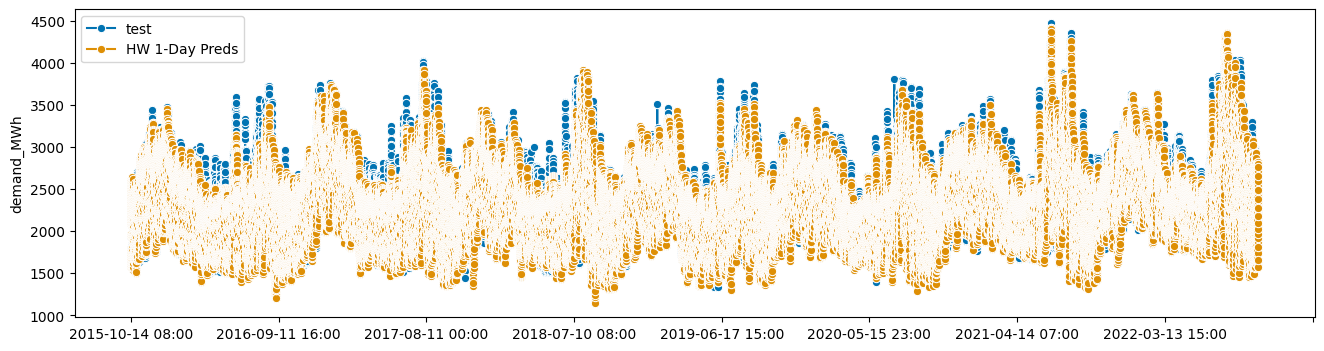

In [177]:
plot_series(y[2016:-11], iter_hwpreds_day_flat, labels=['test', 'HW 1-Day Preds']);

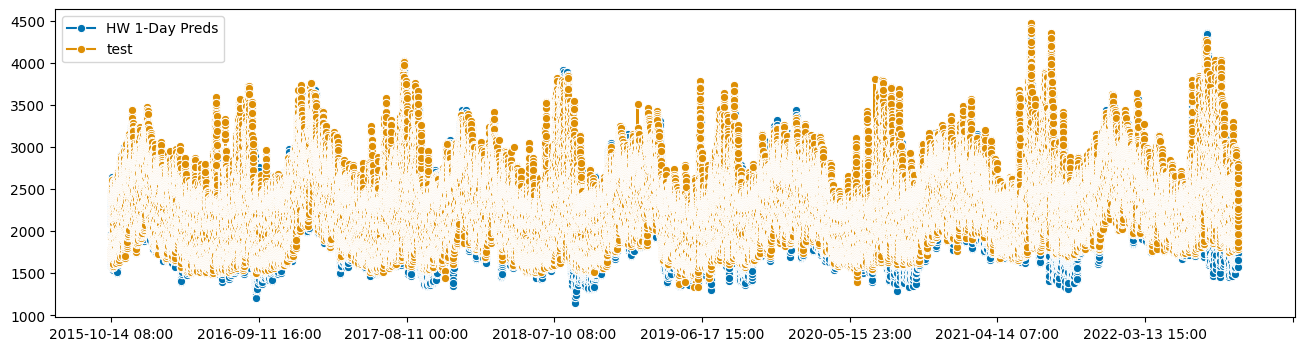

In [178]:
plot_series(iter_hwpreds_day_flat, y[2016:-11], labels=['HW 1-Day Preds', 'test']);

The HW 12-week train model with daily periodicity does a better job of forecasting one day out than one week out, as expected. It does remarkably well with many of the more extreme demand spikes in the summer, and seems to show better coverage of the testing data overall, but overshoots many of the low-demand hours.

**ARIMA(1,0,0)(1,0,0)[24] => SAR(1)[24], 12-week Train, 1-week Forecast:**

In [129]:
iter_sarpreds_week = []

for n in range(363):
    y_12weektrain = y[168*n: 2016 + 168*n]
    
    iter_sar_week = ARIMA(order=(1,0,0), seasonal_order=(1,0,0,24), enforce_stationarity=False, suppress_warnings=True)
    iter_sar_week.fit(y_12weektrain)
    iter_sarpreds_week.append(iter_sar_week.predict(pd.RangeIndex(1, 169)))

In [141]:
iter_sarpreds_week_flat = pd.Series([pred for l in iter_sarpreds_week for pred in l], index=y.index[2016:-83])

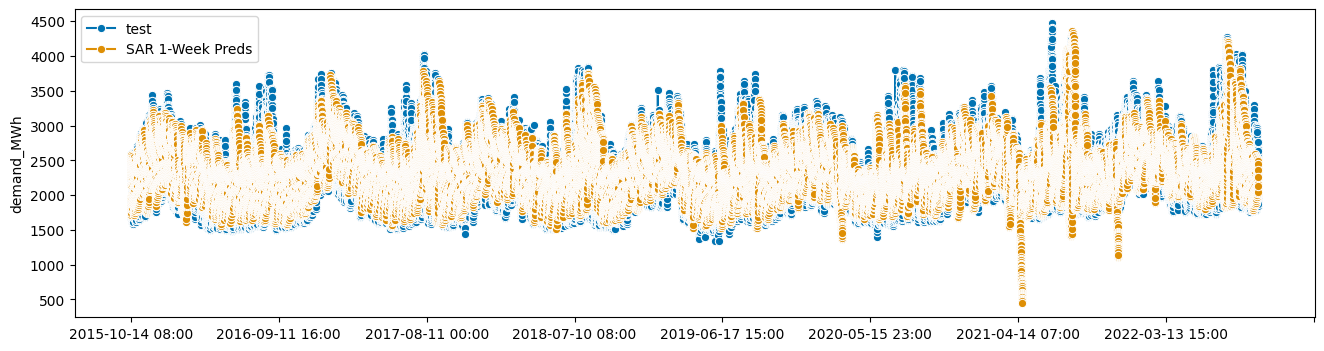

In [142]:
plot_series(y[2016:-83], iter_sarpreds_week_flat, labels=['test', 'SAR 1-Week Preds']);

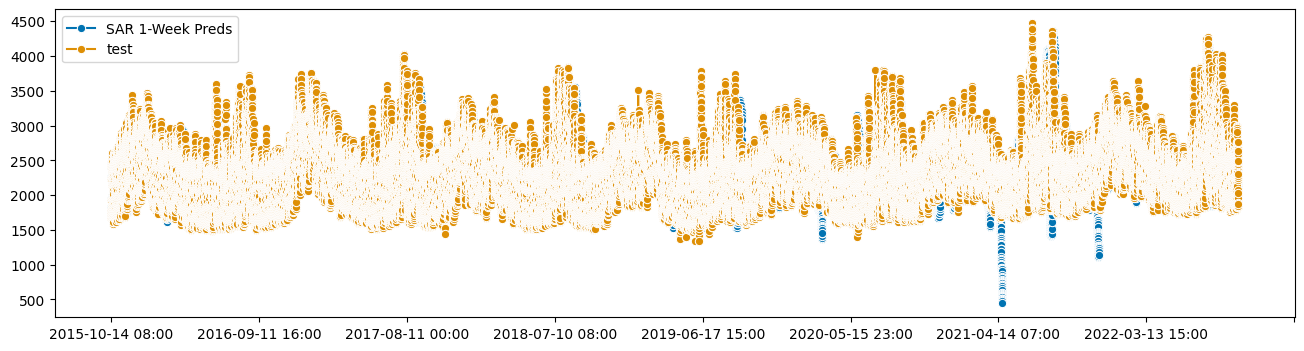

In [143]:
plot_series(iter_sarpreds_week_flat, y[2016:-83], labels=['SAR 1-Week Preds', 'test']);

In [144]:
mean_absolute_error(y[2016:-83], iter_sarpreds_week_flat)

211.12916797009782

**ARIMA 12-week Train, 1-Day Forecast**

In [135]:
iter_sarpreds_day = []

for n in range(2544):
    y_12weektrain = y[24*n: 2016 + 24*n]
    
    iter_sar_day = ARIMA(order=(1,0,0), seasonal_order=(1,0,0,24), enforce_stationarity=False, suppress_warnings=True)
    iter_sar_day.fit(y_12weektrain)
    iter_sarpreds_day.append(iter_sar_day.predict(pd.RangeIndex(1, 25)))

In [136]:
# convert to pandas series
iter_sarpreds_day_flat = pd.Series([pred for l in iter_sarpreds_day for pred in l], index=y.index[2016:-11])

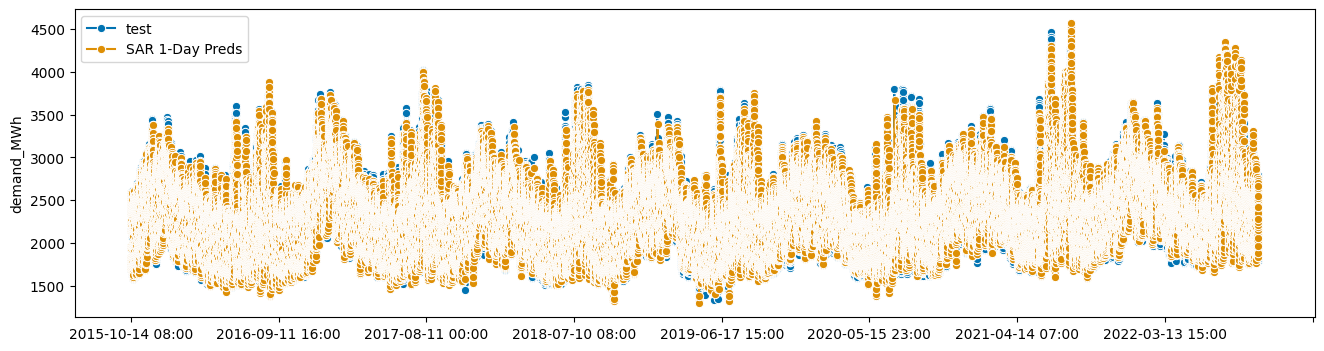

In [138]:
plot_series(y[2016:-11], iter_sarpreds_day_flat, labels=['test', 'SAR 1-Day Preds']);

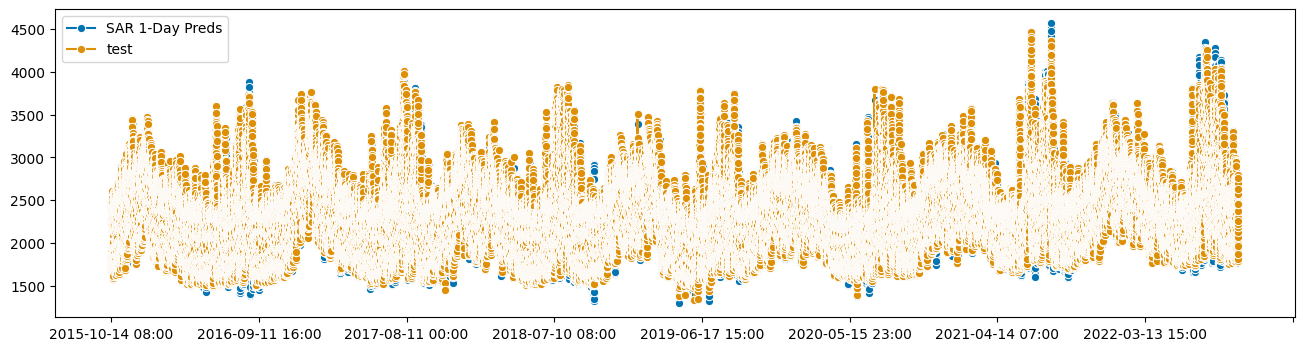

In [139]:
plot_series(iter_sarpreds_day_flat, y[2016:-11], labels=['SAR 1-Day Preds', 'test']);

In [137]:
mean_absolute_error(y[2016:-11], iter_sarpreds_day_flat)

117.00268144974632

### 5. Save Forecasts

In [9]:
iter_hwpreds_week_flat.to_csv('../../data/forecasts/hw_weekpreds.csv')
iter_hwpreds_day_flat.to_csv('../../data/forecasts/hw_daypreds.csv')

iter_sarpreds_week_flat.to_csv('../../data/forecasts/sar1_weekpreds.csv')
iter_sarpreds_day_flat.to_csv('../../data/forecasts/sar1_daypreds.csv')

### 6. SAR Week-Ahead without enforce_stationarity=True
**Errors for certain training periods; kept in notebook for potential future review**
- 10-week train for weeks 285, 339 due to model fitting, forecasting issues

In [11]:
# SAR(1) forecasts for weeks 13 through 284
iter_sarpreds_week = []

for n in range(363):
    y_12weektrain = y[168*n: 2016 + 168*n]
    forecast_index = pd.Series(0, index=[y_12weektrain.index[-1] + 1 + i for i in range(168)]).index
    
    iter_sar_week = ARIMA(order=(1,0,0), seasonal_order=(1,0,0,24))
    iter_sar_week.fit(y_12weektrain)
    iter_sarpreds_week.append(iter_sar_week.predict(forecast_index))

C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Graham\anaconda3\envs\sktim

ValueError: Input contains NaN.

*ValueError: Input contains NaN.*

Error when n=272

In [65]:
iter_sarpreds_week[:2]

[2015-10-14 08:00    1831.338397
 2015-10-14 09:00    1751.916134
 2015-10-14 10:00    1720.719546
 2015-10-14 11:00    1708.993854
 2015-10-14 12:00    1764.045846
                        ...     
 2015-10-21 03:00    2477.604228
 2015-10-21 04:00    2426.539736
 2015-10-21 05:00    2325.246798
 2015-10-21 06:00    2202.676113
 2015-10-21 07:00    2090.141676
 Freq: H, Length: 168, dtype: float64,
 2015-10-21 08:00    1828.347830
 2015-10-21 09:00    1755.717261
 2015-10-21 10:00    1712.076827
 2015-10-21 11:00    1704.910329
 2015-10-21 12:00    1756.668707
                        ...     
 2015-10-28 03:00    2477.924832
 2015-10-28 04:00    2428.087849
 2015-10-28 05:00    2326.844768
 2015-10-28 06:00    2195.507200
 2015-10-28 07:00    2079.832179
 Freq: H, Length: 168, dtype: float64]

In [71]:
iter_sarpreds_week[-2:]

[2020-12-25 07:00    2581.381245
 2020-12-25 08:00    2419.493517
 2020-12-25 09:00    2297.535646
 2020-12-25 10:00    2230.443469
 2020-12-25 11:00    2198.632791
                        ...     
 2021-01-01 02:00    2831.957396
 2021-01-01 03:00    2773.450532
 2021-01-01 04:00    2710.556672
 2021-01-01 05:00    2657.430211
 2021-01-01 06:00    2593.771274
 Freq: H, Length: 168, dtype: float64,
 2021-01-01 07:00    2254.577983
 2021-01-01 08:00    2098.877211
 2021-01-01 09:00    1975.690377
 2021-01-01 10:00    1905.111475
 2021-01-01 11:00    1869.811796
                        ...     
 2021-01-08 02:00    2477.595410
 2021-01-08 03:00    2440.295080
 2021-01-08 04:00    2368.009446
 2021-01-08 05:00    2304.018848
 2021-01-08 06:00    2237.246851
 Freq: H, Length: 168, dtype: float64]

In [55]:
# SAR(1) forecasts for weeks 286 through 338
iter_sarpreds_week_start273 = []

for n in range(273, 363):
    y_12weektrain = y[168*n: 2016 + 168*n]
    forecast_index = pd.Series(0, index=[y_12weektrain.index[-1] + 1 + i for i in range(168)]).index
    
    iter_sar_week = ARIMA(order=(1,0,0), seasonal_order=(1,0,0,24))
    iter_sar_week.fit(y_12weektrain)
    iter_sarpreds_week_start273.append(iter_sar_week.predict(forecast_index))

LinAlgError: LU decomposition error.

*LinAlgError: LU decomposition error.*

Error when n=326

In [63]:
iter_sarpreds_week_start273[:2]

[2021-01-15 07:00    2358.253697
 2021-01-15 08:00    2208.873868
 2021-01-15 09:00    2111.166507
 2021-01-15 10:00    2061.373617
 2021-01-15 11:00    2035.068202
                        ...     
 2021-01-22 02:00    2749.854034
 2021-01-22 03:00    2763.421858
 2021-01-22 04:00    2705.922401
 2021-01-22 05:00    2634.855543
 2021-01-22 06:00    2527.608972
 Freq: H, Length: 168, dtype: float64,
 2021-01-22 07:00     2597.635714
 2021-01-22 08:00     2549.115042
 2021-01-22 09:00     2564.559280
 2021-01-22 10:00     2609.098967
 2021-01-22 11:00     2704.850228
                         ...     
 2021-01-29 02:00    29190.948706
 2021-01-29 03:00    29323.255124
 2021-01-29 04:00    29363.503749
 2021-01-29 05:00    29370.746527
 2021-01-29 06:00    29326.132847
 Freq: H, Length: 168, dtype: float64]

In [64]:
iter_sarpreds_week_start273[-2:]

[2022-01-07 07:00    2495.315151
 2022-01-07 08:00    2315.263317
 2022-01-07 09:00    2184.118623
 2022-01-07 10:00    2112.094889
 2022-01-07 11:00    2067.659582
                        ...     
 2022-01-14 02:00    2737.426352
 2022-01-14 03:00    2715.108245
 2022-01-14 04:00    2669.576674
 2022-01-14 05:00    2614.437268
 2022-01-14 06:00    2530.773174
 Freq: H, Length: 168, dtype: float64,
 2022-01-14 07:00    2443.175549
 2022-01-14 08:00    2294.000673
 2022-01-14 09:00    2184.667413
 2022-01-14 10:00    2111.469573
 2022-01-14 11:00    2093.864685
                        ...     
 2022-01-21 02:00    2802.293514
 2022-01-21 03:00    2776.496175
 2022-01-21 04:00    2726.662775
 2022-01-21 05:00    2661.000750
 2022-01-21 06:00    2569.543926
 Freq: H, Length: 168, dtype: float64]

In [58]:
# SAR(1) forecasts for weeks 340 through 375
iter_sarpreds_week_start327 = []

for n in range(327, 363):
    y_12weektrain = y[168*n: 2016 + 168*n]
    forecast_index = pd.Series(0, index=[y_12weektrain.index[-1] + 1 + i for i in range(168)]).index
    
    iter_sar_week = ARIMA(order=(1,0,0), seasonal_order=(1,0,0,24))
    iter_sar_week.fit(y_12weektrain)
    iter_sarpreds_week_start327.append(iter_sar_week.predict(forecast_index))

In [61]:
iter_sarpreds_week_start327[:2]

[2022-01-28 07:00    2819.162062
 2022-01-28 08:00    2651.885080
 2022-01-28 09:00    2562.552324
 2022-01-28 10:00    2511.308278
 2022-01-28 11:00    2505.563495
                        ...     
 2022-02-04 02:00    2877.793246
 2022-02-04 03:00    2913.697905
 2022-02-04 04:00    2876.824645
 2022-02-04 05:00    2820.614083
 2022-02-04 06:00    2738.604385
 Freq: H, Length: 168, dtype: float64,
 2022-02-04 07:00    2584.202430
 2022-02-04 08:00    2405.258498
 2022-02-04 09:00    2294.427981
 2022-02-04 10:00    2228.382128
 2022-02-04 11:00    2208.054325
                        ...     
 2022-02-11 02:00    2843.332676
 2022-02-11 03:00    2897.090121
 2022-02-11 04:00    2858.419210
 2022-02-11 05:00    2823.440471
 2022-02-11 06:00    2738.548468
 Freq: H, Length: 168, dtype: float64]

In [62]:
iter_sarpreds_week_start327[-2:]

[2022-09-23 07:00    2063.546218
 2022-09-23 08:00    1934.811023
 2022-09-23 09:00    1869.022054
 2022-09-23 10:00    1810.612012
 2022-09-23 11:00    1799.404990
                        ...     
 2022-09-30 02:00    2436.311135
 2022-09-30 03:00    2433.803655
 2022-09-30 04:00    2404.368585
 2022-09-30 05:00    2320.540271
 2022-09-30 06:00    2210.954647
 Freq: H, Length: 168, dtype: float64,
 2022-09-30 07:00    2085.968152
 2022-09-30 08:00    1977.320829
 2022-09-30 09:00    1914.941447
 2022-09-30 10:00    1878.468065
 2022-09-30 11:00    1873.454141
                        ...     
 2022-10-07 02:00    2524.412142
 2022-10-07 03:00    2538.039742
 2022-10-07 04:00    2495.215459
 2022-10-07 05:00    2412.812726
 2022-10-07 06:00    2311.195983
 Freq: H, Length: 168, dtype: float64]

In [84]:
# forecast for week 285 (n = 272)
n=272
iter_sarpreds_week285 = []
y_10weektrain = y[336 + 168*n: 2016 + 168*n]
forecast_index = pd.Series(0, index=[y_10weektrain.index[-1] + 1 + i for i in range(168)]).index

iter_sar_week = ARIMA(order=(1,0,0), seasonal_order=(1,0,0,24))
iter_sar_week.fit(y_10weektrain)
iter_sarpreds_week285.append(iter_sar_week.predict(forecast_index))


# forecast for week 339 (n = 326)
n=326
iter_sarpreds_week339 = []
y_10weektrain = y[336 + 168*n: 2016 + 168*n]
forecast_index = pd.Series(0, index=[y_10weektrain.index[-1] + 1 + i for i in range(168)]).index

iter_sar_week = ARIMA(order=(1,0,0), seasonal_order=(1,0,0,24))
iter_sar_week.fit(y_10weektrain)
iter_sarpreds_week339.append(iter_sar_week.predict(forecast_index))

In [85]:
iter_sarpreds_week285

[2021-01-08 07:00    2455.283984
 2021-01-08 08:00    2295.433849
 2021-01-08 09:00    2169.390403
 2021-01-08 10:00    2117.477052
 2021-01-08 11:00    2080.611506
                        ...     
 2021-01-15 02:00    2853.910065
 2021-01-15 03:00    2847.909779
 2021-01-15 04:00    2792.185219
 2021-01-15 05:00    2724.370321
 2021-01-15 06:00    2615.759452
 Freq: H, Length: 168, dtype: float64]

In [86]:
iter_sarpreds_week339

[2022-01-21 07:00    2445.761103
 2022-01-21 08:00    2286.590578
 2022-01-21 09:00    2173.040769
 2022-01-21 10:00    2104.180657
 2022-01-21 11:00    2064.182229
                        ...     
 2022-01-28 02:00    2782.313185
 2022-01-28 03:00    2796.897910
 2022-01-28 04:00    2765.385705
 2022-01-28 05:00    2713.250720
 2022-01-28 06:00    2627.149395
 Freq: H, Length: 168, dtype: float64]

In [90]:
# compile forecasts
comp_iter_sarpreds_week = iter_sarpreds_week + iter_sarpreds_week285 + iter_sarpreds_week_start273 + iter_sarpreds_week339 + iter_sarpreds_week_start327

# convert to pandas series
comp_iter_sarpreds_week_flat = pd.Series([pred for l in comp_iter_sarpreds_week for pred in l], index=y.index[2016:-83])

In [100]:
mean_absolute_error(y[2016:-83], comp_iter_sarpreds_week_flat)

607.2833186553063

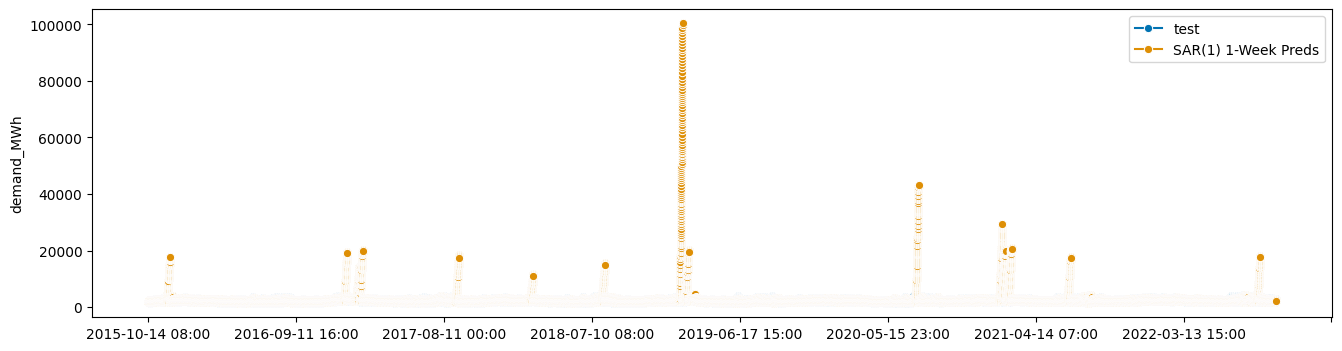

In [101]:
plot_series(y[2016:-83], comp_iter_sarpreds_week_flat, labels=['test', 'SAR(1) 1-Week Preds']);